# Dependencies

In [35]:
!pip install pyworld
!pip install soundfile
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install panda
!apt-get install libsndfile-dev -y

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
#import torch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libsndfile1-dev' instead of 'libsndfile-dev'
libsndfile1-dev is already the newest version (1.0.28-4).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
gpg: keybox '/tmp/tmpicvkxjpx/pubring.gpg' created
gpg: /tmp/tmpicvkxjpx/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


## Google Drive Integration

In [0]:
##https://colab.research.google.com/notebook#fileId=1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q&scrollTo=XoDG4oKpoeyS

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [37]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [38]:
# Create a directory and mount Google Drive using that directory.
!fusermount -u drive
!rmdir drive
!mkdir -p drive

!google-drive-ocamlfuse drive


fusermount: failed to unmount /content/drive: No such file or directory
rmdir: failed to remove 'drive': No such file or directory


In [40]:
import os
print('Files in Drive:')
basePath = 'drive/Colab Notebooks/TigerCostume'
print(os.listdir(basePath))



# Create a file in Drive.
#!echo "This newly created file will appear in your Drive file list." > drive/created.tx

Files in Drive:
['tiger_costume.ipynb', 'images', 'citations', 'sounds', 'train_samples', 'papers', 'IEEE_days.ipynb']


## Functions

In [41]:
from google.colab import files
from IPython.core.display import HTML
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pyworld as pw
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
from scipy.fftpack import dct

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

configure_plotly_browser_state()

init_notebook_mode(connected=False)

def upload_stuff():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
    with open(fn, 'w') as f:
      f.write(uploaded[fn])
  
  return uploaded

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" autoplay style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))
    
#upload_stuff()

import pyworld as pw
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

def from_wav(file):
    x, fs  = sf.read(file)

    if x.ndim is 2:
        x = x[:, 0]
    x = x.copy(order='C').astype(float)
    return x,fs

def train_samples(x, fs, t1=400, t2=10, nth1=50, nth2=20):
    """Returns chunks of train samples from signal

    Args:
        x: Complete signal
        fs: Sample frequency
        t1: Duration of window (ms)
        t2: Slide length (ms)
        nth1: Upper threshold
        nth2: Bottom threshold


    Returns:
        Returns train samples of equal length

    """
    
    t = np.divide(np.arange(0, x.shape[0]),fs)

    L1 = x.shape[0] # Signal length
    # T1 = 600*1e-3 # Window length
    # T2 = 20*1e-3 # Step lenght
    T1 = t1*1e-3 # Window length
    T2 = t2*1e-3 # Step lenght
    N1 = np.floor(T1*fs).astype(int) # Samples per window
    D1 = np.floor(T2*fs).astype(int) # Samples per step
    indice  = np.arange(1,L1,D1,dtype=np.int32) # Start indexes for windowing

    noise_power = np.sum(np.power(np.absolute(x[0:np.floor(fs).astype(int)-1]),2))
    noise_th1 = nth1*noise_power
    noise_th2 = nth2*noise_power
    sflag = 0
    clip  = np.zeros(x.shape)
    wp = np.zeros(x.shape)
    chunks = [];

    for i in np.arange(1,indice.shape[0]-2):
       fin = np.min([indice[i]+N1, x.shape[0]]).astype(int)
       window_power = np.sum(np.power(np.absolute(x[indice[i]:fin]),2))
       if (window_power > noise_th1 and sflag==0):
          sflag = 1
          clip[indice[i]] = window_power
          chunks.append(indice[i]);
       elif ( window_power < noise_th2 and sflag==1 ):
            clip[indice[i]+N1] = window_power
            sflag = 0
            chunks.append(indice[i]+N1)
       wp[indice[i]] = window_power;

    fig, ax1 = plt.subplots()
    ax1.plot(t, x, 'b-')
    ax1.set_xlabel('time (s)')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('signal', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(t, clip, 'r.')
    ax2.set_ylabel('wp', color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    plt.show()

    max_chunk_dur = np.max(np.subtract(chunks[1:2:],chunks[0:2:]))

    train_samples = np.zeros(((int)(len(chunks)/2), max_chunk_dur))

    ti = 0;
    for i in np.arange(0, len(chunks), 2):
       chunk_dur = chunks[i+1]-chunks[i];
       chunk_diff = max_chunk_dur - chunk_dur;
       if (np.mod(chunk_diff,2) == 0) :
            off_s = (int)(chunk_diff/2);
            off_e = off_s;
       else :
           off_s = np.floor(chunk_diff/2).astype(int);
           off_e = off_s+1;
       train_samples[[ti],:] = x[chunks[i]-off_s:chunks[i+1]+off_e];
       #soundsc(s(chunks(i):chunks(i+1)),fs)
       #pause
       ti = ti+1

    return train_samples

# Mel Cepstrum Generation
75% completed in numpy


44100


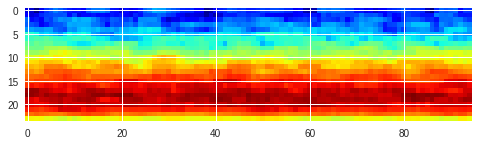

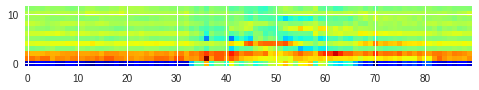

In [48]:
# Cepstrum Generation in NUMPY

def windower(x, M, N):
    # M avance entre vetanas
    # N windowsize

    T   = x.shape[0]
    m   = np.arange(0, T-N-1, M) # comienzos de ventana
    L   = m.shape[0] # N ventanas
    ind = np.expand_dims(np.arange(0, N), axis=1) * np.ones((1,L)) + np.ones((N,1)) * m
    X   = x[ind.astype(int)]
    return X.transpose()
  
def gen_mfb_mtx(NFFT, nfilt, sample_rate):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    return fbank


sample_rate = fs
print(fs)
#a = np.random.randn(10000)
a = ts_javi[7,:]
N = np.round(0.03 * sample_rate).astype(int)
M = np.round(0.01 * sample_rate).astype(int)
A = windower(a, M, N)

NFFT = 2048
# nwindows, NFFT/2
s = np.fft.rfft(A, n=2048, axis=1)
W = np.expand_dims(np.hamming(s.shape[1]), axis=0)
s = np.abs(s) * W
pow_frames = ((1.0 / NFFT) * (s ** 2))  # Power Spectrum

nfilt = 24

############ MFB
# nfilt, NFFT/2
fbank = gen_mfb_mtx(NFFT, nfilt, sample_rate)
#print(fbank.shape)
#print(pow_frames.shape)
        
 # (nwindows, nfilts)       
filtered_s = np.dot(s, fbank.T)
filtered_s = np.where(filtered_s == 0, np.finfo(float).eps, filtered_s)  # Numerical Stability
log_filtered_s = np.log(filtered_s)  # dB

############## DCT
num_ceps = 12
mfcc = dct(log_filtered_s, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

# sinusoidal liftering to improve speech performance in noisy scenarios
# (nframes, ncoeff) = mfcc.shape
# n = numpy.arange(ncoeff)
# lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
# mfcc *= lift  


# Nwindows, num_ceps
mfcc -= np.expand_dims(np.mean(mfcc, axis=1) + 1e-8, 1)

#############
plt.figure()
plt.imshow(mel_cepstrum.T, cmap='jet')
plt.figure()
plt.imshow(mfcc.T, cmap='jet')
plt.gca().invert_yaxis()

# Dynamic time warping
100% implemented in numpy.
75% done in pytorch.

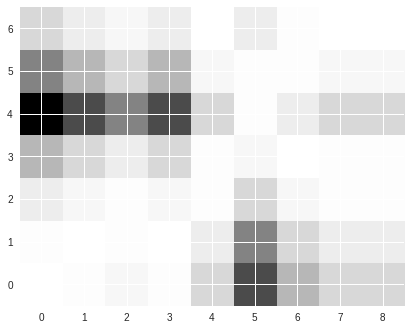

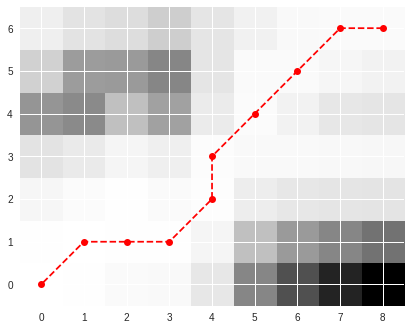

In [45]:
# Dynamic time warping in NUMPY
import numpy as np
import matplotlib.pyplot as plt

def elementwyse_l2(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    if x.ndim is 1:
        x = x.reshape(-1,1)
        x_norm = (x**2).reshape(-1, 1)
    else:
        x_norm = (x**2).sum(1).reshape(-1, 1)
        
    if y is not None:
        if y.ndim is 1:
            y = y.reshape(-1, 1)
            y_norm = (y**2).reshape(1, -1)
        else:
            y_norm = (y**2).sum(1).reshape(1, -1)
    else:
        y = x
        y_norm = x_norm.reshape(1, -1)

    dist = x_norm + y_norm - 2.0 * np.matmul(x, y.T)
    return dist
  
def genate_Cmtx(dists):  
  sz = dists.shape
  c = dists
  d = 100000*np.ones(sz)
  #torch:
  #sz[0] = i vertical
  #sz[1] = j horizontal
  d[:, 0] = c[:, 0]
  
  for j in range(1, sz[1]):
    for i in range(sz[0]):

      if i is 0:
        d[i, j] = c[i,j] + d[i,j-1]
      else:
        d[i, j] = c[i,j] + np.array([d[i,j-1], d[i-1,j], d[i-1,j-1]]).min()
        
  return d  

def dtw_backtracking(c, start):
  # Work in progress
  posV = np.array([start[0]])
  posH = np.array([start[1]])
  i = 0
  
  while posH[i] != 0:
    
    if posV[i] == 0:
      opts = 2

    else:
      opt1 = c[posV[i] - 1, posH[i]]
      opt2 = c[posV[i], posH[i] - 1]
      opt3 = c[posV[i] - 1, posH[i] - 1]
      
      aa = np.array([opt1, opt2, opt3], dtype=np.float32)
      opts = np.argmin(aa)
      
    nextV = posV[i] - (opts == 0 or opts == 2)
    nextH = posH[i] - (opts == 1 or opts == 2)

    posV = np.append(posV, nextV)
    posH = np.append(posH, nextH)
    
    i += 1
    
  
  return posV, posH
  
  
s = np.array([0, 1, 3, 5, 8, 6, 4])
t = np.array([0, 1, 2, 1, 4, 7, 5, 4, 4])

D = elementwyse_l2(s, t)
C = genate_Cmtx(D)
start = [6,8]
posV, posH = dtw_backtracking(C, start)

plt.figure()
plt.imshow(D)
plt.gca().invert_yaxis()
plt.figure()
plt.imshow(C)
plt.plot(posH, posV, 'r--o')
plt.gca().invert_yaxis()


In [0]:
# Dynamic time warping in PYTORCH
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile as wf
file_alberto = 'clip1.wav'
file_javi = 'clip1.wav'

fs, x_alberto = wf.read(file_alberto)
fs, x_javi = wf.read(file_javi)


# def elementwyse_l2(x, y=None):
  
#   if y is None:
#     y = x
#   # input 
#   #Nx = x.shape[0]
#   #Ny = y.shape[0]
#   #dims = x.shape[1]
  
#   dist = (x.unsqueeze(1) - y.unsqueeze(0)).pow(2).sum(2)
#   return dist
#this function is an alternative to the previous

s = torch.FloatTensor([0, 1, 3, 5, 8, 6, 4])
t = torch.FloatTensor([0, 1, 2, 1, 4, 7, 5, 4, 4])

def elementwyse_l2_pt(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x = x.view(x.shape[0], -1)
    print(x.shape)
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y = y.view(y.shape[0], -1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist

def genate_Cmtx_pt(dists):  
  sz = dists.shape
  c = dists
  d = 100000*torch.ones(sz)
  #torch:
  #sz[0] = i vertical
  #sz[1] = j horizontal
  d[:, 0] = c[:, 0]
  
  for j in range(1, sz[1]):
    for i in range(sz[0]):

      if i is 0:
        d[i, j] = c[i,j] + d[i,j-1]
      else:
        d[i, j] = c[i,j] + torch.FloatTensor([d[i,j-1], d[i-1,j], d[i-1,j-1]]).min()
        
  return d

# TO BE COMPLETED
# def dtw_backtracking_pt(c, start):
#   # Work in progress
#   posV = torch.IntTensor([start[0]])
#   posH = torch.IntTensor([start[1]])
#   i = 0
  
#   while posH[i] != 0:
    
#     if posV[i] is 0:
#       opts = 2
#       addcost = c[posV[i], posH[i] - 1]

#     else:
#       opt1 = c[posV[i] - 1, posH[i]]
#       opt2 = c[posV[i], posH[i] - 1]
#       opt3 = c[posV[i] - 1, posH[i] - 1]
#       [addcost, opts] = torch.min(torch.FloatTensor([opt1, opt2, opt3]))
#       print(opts)
      
#     nextV = torch.IntTensor([posV[i] - (opts == 1 or opts == 3)])
#     nextH = torch.IntTensor([posH[i] - (opts == 2 or opts == 3)])

#     posV = torch.cat((posV, nextV), 0)
#     posH = torch.cat((posH, nextH), 0)
    
#     i += 1
    
  
#   return posV, posH


XA = torch.ones(4,2)
XJ = torch.ones(6,2)*3

D = elementwyse_l2_pt(s, t)
C = genate_Cmtx_pt(D)
start = torch.IntTensor([6,8])
posV, posH = dtw_backtracking_pt(C, start)

plt.figure()
plt.imshow(D)

plt.figure()
plt.imshow(C)
plt.scatter(posH, posV, color='r')


  

torch.Size([7, 1])


TypeError: ignored

#Regression. Dense linear model. Fitted with ML. 
#p(w|alpha, Beta, D): p(D|w, Beta)*p(W|alpha)

---



*   Adjustable Weight decay -> 0 Mean Normal prior on weights: W ~N(0, Alpha^-1) to avoid fitting noise. Also ensures matrix invertibility.
*   Adjustable Beta uncertainty factor to model noise. t ~N(y=w*x, Beta^-1)
*   Noise sensibility ~Beta/Alpha

Residuals converge to noise variance with enough training points


In [0]:
#### linear regresion

import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1337)
Noise_var = 3
dims = 3

Ntrain = 1000

x_t = 5 * np.ones((Ntrain, dims))
t_t = 40 * np.ones((Ntrain, dims)) + np.sqrt(Noise_var) * np.random.randn(Ntrain, dims)

x_train = torch.from_numpy(x_t)
t_train = torch.from_numpy(t_t)


class dense_linear_LS(nn.Module):
    def __init__(self):
        super(dense_linear_LS, self).__init__()
        self.W = None  # Weights

    def forward(self, x):
        # x = inputs (Nsamples, dim)
        # y = outputs (Nsamples, dim)
        bx = torch.ones(x.shape[0], 1).type(torch.DoubleTensor)
        x = torch.cat((bx, x), 1).t()
        y = self.W.t().matmul(x)
        return y

    def fit(self, x, t, alpha=0.0000001, beta=1, bias=True):
        # x = inputs (Nsamples, dim)
        # t = targets (Nsamples, dim)
        # residuals = output (Nsamples, dim)
        bx = torch.ones(x.shape[0], 1).type(torch.DoubleTensor)
        a = torch.cat((bx, x), dim=1)
        wd = alpha * torch.eye(a.shape[1]).type(torch.DoubleTensor)
        inner = torch.matmul(a.t(), a)
        pseusoInvX = torch.inverse(wd + beta * inner).matmul(beta * a.t())
        self.W = pseusoInvX.matmul(t)
        if bias == False:
            self.W[0, :] = 0
        residuals = t - self.forward(x)
        return residuals
        
        
        
model = dense_linear_LS()

res = model.fit(x_train, t_train, beta=1, bias=False)
residual_var = res.pow(2).mean()
print('residual variance = %f' % residual_var)
print(model.W)

x_test = 5 * torch.ones(1, dims).type(torch.DoubleTensor)
print(model(x_test))

residual variance = 3.141661

 0.0000  0.0000  0.0000
 2.6292  2.6357  2.6330
 2.6289  2.6355  2.6327
 2.6290  2.6355  2.6327
[torch.DoubleTensor of size 4x3]


 39.4357
 39.5335
 39.4920
[torch.DoubleTensor of size 3x1]




# Regression. 2 layer NN, 1 hidden layer. 


Define Model and Auxiliary functions 

In [0]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

class BaseNet(object):
    def __init__(self):
        self.epoch = 0

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch


      
class one_hidden_layer(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(one_hidden_layer, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, output_dim)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        self.act = nn.Sigmoid()
        #self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        # -----------------
        a = self.fc1(x)
        # -----------------
        z = self.act(a)
        # -----------------
        y = self.fc2(z)
        return y
      

class Net(BaseNet):
    def __init__(self, input_dim, output_dim, n_hid, lr=1e-4, cuda=True):
        super(Net, self).__init__()
        cprint('c', '\nNet:')
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_hid = n_hid
        self.cuda = cuda
        self.create_net()
        self.create_opt(lr)

    def create_net(self):
        self.model = one_hidden_layer(self.input_dim, self.output_dim, self.n_hid)
        self.J = MSELoss(size_average=True, reduce=True)
        if self.cuda:
            self.model.cuda()
            self.J.cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in self.model.parameters()) / 1000000.0))

    def create_opt(self, lr=1e-4):
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.schedule = None  # [-1] #[50,200,400,600]

    def fit(self, x, y):
        x, y = to_variable(var=(x, y), volatile=False, cuda=self.cuda)

        self.optimizer.zero_grad()
        out = self.model(x)
        loss = self.J(out, y)
        loss.backward()
        self.optimizer.step()

        return loss.data[0]

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y), volatile=True, cuda=self.cuda)

        out = self.model(x)
        loss = self.J(out, y)
        return loss.data[0]

    def predict(self, x, train=False):
        x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)

        out = self.model(x)
        return out.data

#     def extract(self, x, train=False):
#         x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)

#         _, e = self.model(x)
#         return e.data

Create train loop

In [0]:
from __future__ import absolute_import, division, print_function
# --------------------

net = Net(input_dim, output_dim, n_hid)

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c','\nTrain:')

cost_train = np.zeros(nb_epochs)
cost_dev = np.zeros(nb_epochs)

nb_samples_train = len(x_train)
nb_samples_dev = len(x_dev)

best_cost = np.inf
nb_its_dev = 1
tic0 = time.time()
for i in range(nb_epochs):
    net.set_mode_train(True)
    # ---- W
    tic = time.time()
    #for x, y in trainloader:        
    for ind in generate_ind_batch(nb_samples_train, batch_size):
        x, y = x_train[ind], y_train[ind]
        loss  = net.fit(x, y)
        cost_train[i] += loss / nb_samples_train * len(x)
        err_train[i] += err / nb_samples_train

    toc = time.time()

    # ---- print
    print("it %d/%d, Jtr = %f, err = %f, " % (i, nb_epochs, cost_train[i],err_train[i]), end="")
    cprint('r','   time: %f seconds\n' % (toc - tic))
    net.update_lr(i)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        #print('eval mode on')
        #for x, y in testloader:
        for ind in generate_ind_batch(nb_samples_dev, batch_size, random=False):
            x, y = x_dev[ind], y_dev[ind]
            cost, err =  net.eval(x, y)
            cost_dev[i] += cost / nb_samples_dev * len(x)
            err_dev[i] += err / nb_samples_dev
        cprint('g','    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))
        if cost_dev[i] < best_cost:
            best_cost = cost_dev[i]
            net.save('./theta_best.dat')

toc0 = time.time()
runtime_per_it =  (toc0 - tic0)/float(nb_epochs)
cprint('r','   average time: %f seconds\n' % runtime_per_it)

## ---------------------------------------------------------------------------------------------------------------------
# save model
net.save('./theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c','\nRESULTS:')
cost_dev_min = cost_dev[::nb_its_dev].min()
err_dev_min = err_dev[::nb_its_dev].min()
cost_train_min = cost_train.min()
nb_parameters = net.get_nb_parameters()
print('  cost_dev: %f (cost_train %f)' % (cost_dev_min, cost_train_min))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

In [0]:
np.random.seed(1337)
Noise_var = 3
dims = 3

Ntrain = 1000

x_t = 5 * np.ones((Ntrain, dims))
t_t = 40 * np.ones((Ntrain, dims)) + np.sqrt(Noise_var) * np.random.randn(Ntrain, dims)

x_train = torch.from_numpy(x_t)
t_train = torch.from_numpy(t_t)

        
        
        
model = dense_linear_LS()

res = model.fit(x_train, t_train, beta=1, bias=False)
residual_var = res.pow(2).mean()
print('residual variance = %f' % residual_var)
print(model.W)

x_test = 5 * torch.ones(1, dims).type(torch.DoubleTensor)
print(model(x_test))

# PyWorld Function Analysis

## Simple reconstruction

Nwindows = 1447
(1447, 1025)


Text(0,0.5,u'band aperiodicities')

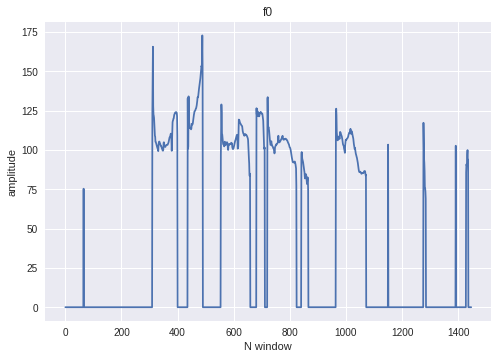

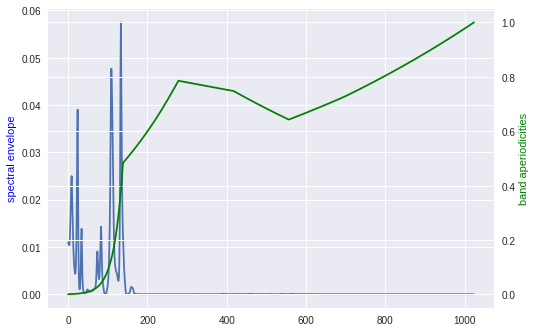

In [0]:
import pyworld as pw
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

file = basePath + '/sounds/clip1.wav'

x, fs  = sf.read(file)
if x.ndim is 2:
    x = x[:, 0]
x = x.copy(order='C')

f0, sp, ap = pw.wav2world(x.astype(float), fs)
y = pw.synthesize(f0, sp, ap, fs, pw.default_frame_period)
sf.write(basePath + "/sounds/reconstruct_" + os.path.basename(file), y, fs)


Nwindows = f0.shape[0]
print("Nwindows = %d" % Nwindows)
print(sp.shape)


plt.figure()
plt.plot(range(Nwindows), f0)
plt.title("f0")
plt.xlabel("N window")
plt.ylabel("amplitude")


nWindow = 370

plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(sp[nWindow,1:])
ax1.set_ylabel('spectral envelope', color='b')
ax2.plot(ap[nWindow,1:], 'g')
ax2.set_ylabel('band aperiodicities', color='g')



## Harvest F0 extraction algorithm

In [0]:
"""Harvest F0 extraction algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    fs : int
        Sample rate of input signal in Hz.
    f0_floor : float
        Lower F0 limit in Hz.
        Default: 71.0
    f0_ceil : float
        Upper F0 limit in Hz.
        Default: 800.0
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    Returns
    -------
    f0 : ndarray
        Estimated F0 contour.
    temporal_positions : ndarray
        Temporal position of each frame.
    """

f0_floor = 71.0
f0_ceil = 800.0
frame_period = 5.0
f0, temporal_positions = pw.harvest(x, fs,f0_floor, f0_ceil, frame_period)

#plt.figure()
#plt.plot(temporal_positions, f0)


## DIO F0 extraction algorithm

(1447,)


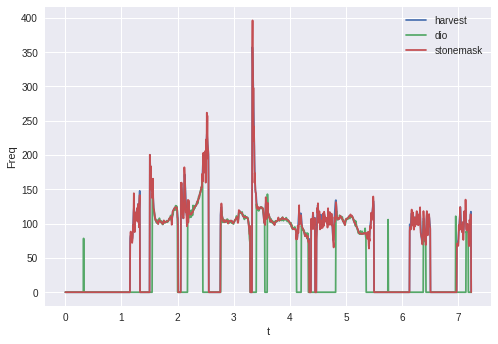

In [0]:
"""DIO F0 extraction algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    fs : int
        Sample rate of input signal in Hz.
    f0_floor : float
        Lower F0 limit in Hz.
        Default: 71.0
    f0_ceil : float
        Upper F0 limit in Hz.
        Default: 800.0
    channels_in_octave : float
        Resolution of multiband processing; normally shouldn't be changed.
        Default: 2.0
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    speed : int
        The F0 estimator may downsample the input signal using this integer factor
        (range [1;12]). The algorithm will then operate on a signal at fs/speed Hz
        to reduce computational complexity, but high values may negatively impact
        accuracy.
        Default: 1 (no downsampling)
    allowed_range : float
        Threshold for voiced/unvoiced decision. Can be any value >= 0, but 0.02 to 0.2
        is a reasonable range. Lower values will cause more frames to be considered
        unvoiced (in the extreme case of `threshold=0`, almost all frames will be unvoiced).
        Default: 0.1
    Returns
    -------
    f0 : ndarray
        Estimated F0 contour.
    temporal_positions : ndarray
        Temporal position of each frame.
    """

f0_floor = 71.0
f0_ceil = 800.0
channels_in_octave = 2.0
frame_period = 5
speed= 1
allowed_range = 0.1
f0_dio, temporal_positions_dio = pw.dio(x, fs,f0_floor, f0_ceil, channels_in_octave, 
                                frame_period, speed, allowed_range)

"""StoneMask F0 refinement algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    Returns
    -------
    refined_f0 : ndarray
        Refined F0 contour.
    """
f0_sm = pw.stonemask(x, f0, temporal_positions, fs)

plt.figure()
plt.plot(temporal_positions, f0, label="harvest")
plt.plot(temporal_positions, f0_dio, label="dio")
plt.plot(temporal_positions, f0_sm, label="stonemask")
plt.ylabel('Freq')
plt.xlabel('t')
print(f0.shape)

plt.legend()

## CheapTrick harmonic spectral envelope estimation algorithm

(1447, 1025)


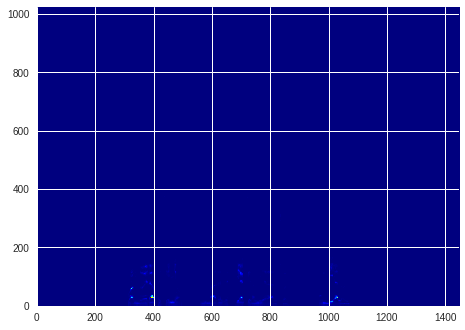

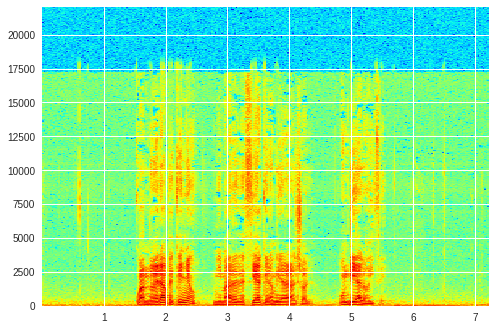

In [0]:
"""CheapTrick harmonic spectral envelope estimation algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    q1 : float
        Spectral recovery parameter.
        Default: -0.15 (this value was tuned and normally does not need adjustment)
    f0_floor : float, None
        Lower F0 limit in Hz. Not used in case `fft_size` is specified.
        Default: 71.0
    fft_size : int, None
        FFT size to be used. When `None` (default) is used, the FFT size is computed
        automatically as a function of the given input sample rate and F0 floor.
        When `fft_size` is specified, the given `f0_floor` parameter is ignored.
        Default: None
    Returns
    -------
    spectrogram : ndarray
        Spectral envelope (squared magnitude).
    """
f0_sp = f0;
q1 = -0.15
f0_floor = 71.0
fft_size = pw.get_cheaptrick_fft_size(fs,f0_floor)

sp = pw.cheaptrick(x, f0_sp, temporal_positions, fs, q1, f0_floor, fft_size)

print(sp.shape)

#plt.figure()
#print(ap.std())
#plt.plot(temporal_positions,ap.std(1))
plt.figure()
plt.imshow(sp.T,cmap="jet")
plt.gca().invert_yaxis()
plt.figure()
Pxx, freqs, bins, im = plt.specgram(x, NFFT=fft_size, Fs=fs, noverlap=900,cmap="jet")
plt.show()



## D4C aperiodicity estimation algorithm

In [0]:
"""D4C aperiodicity estimation algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    threshold : float
        Threshold for aperiodicity-based voiced/unvoiced decision, in range 0 to 1.
        If a value of 0 is used, voiced frames will be kept voiced. If a value > 0 is
        used some voiced frames can be considered unvoiced by setting their aperiodicity
        to 1 (thus synthesizing them with white noise). Using `threshold=0` will result
        in the behavior of older versions of D4C. The current default of 0.85 is meant
        to be used in combination with the Harvest F0 estimator, which was designed to have
        a high voiced/unvoiced threshold (i.e. most frames will be considered voiced).
        Default: 0.85
    fft_size : int, None
        FFT size to be used. When `None` (default) is used, the FFT size is computed
        automatically as a function of the given input sample rate and the default F0 floor.
        When `fft_size` is specified, it should match the FFT size used to compute
        the spectral envelope (i.e. `fft_size=2*(sp.shape[1] - 1)`) in order to get the
        desired results when resynthesizing.
        Default: None
    Returns
    -------
    aperiodicity : ndarray
        Aperiodicity (envelope, linear magnitude relative to spectral envelope).
    """

threshold = 0.85
ap = pw.d4c(x, f0_sp, temporal_positions, fs, threshold, fft_size)

print(ap.shape)

(1447, 1025)


## WORLD synthesis from parametric representation

In [0]:
"""WORLD synthesis from parametric representation.
    Parameters
    ----------
    f0 : ndarray
        Input F0 contour.
    spectrogram : ndarray
        Spectral envelope.
    aperiodicity : ndarray
        Aperodicity envelope.
    fs : int
        Sample rate of input signal in Hz.
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    Returns
    -------
    y : ndarray
        Output waveform signal.
    """
f0, sp, ap = pw.wav2world(x.astype(float), fs)

y = pw.synthesize(f0,sp,ap,fs,frame_period)

print(y.shape)

sf.write(basePath + "/sounds/reconstruct_" + os.path.basename(file), y, fs)


(319063,)


# Run stuff here

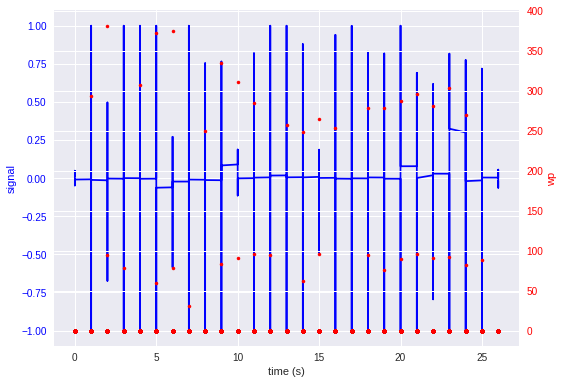

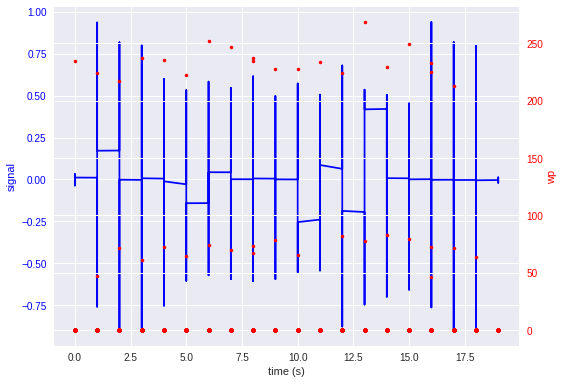

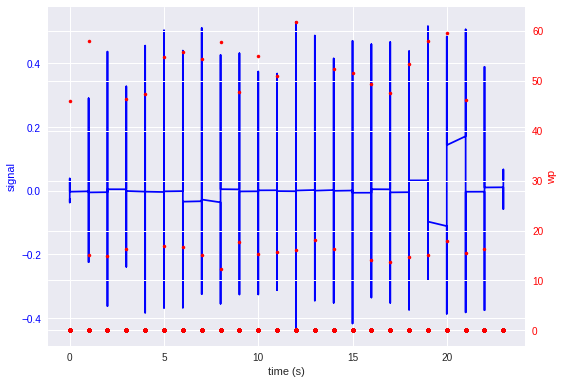

In [42]:
file_javi = basePath + '/train_samples/javi_uno.wav'
file_alberto = basePath + '/train_samples/alberto_uno.wav'
file_raquel = basePath + '/train_samples/raquel_uno_mod.wav'


x_javi,fs = from_wav(file_javi)

ts_javi = train_samples(x_javi,fs)


x_raq,fs = from_wav(file_raquel)

ts_raq = train_samples(x_raq,fs)

x_alb,fs = from_wav(file_alberto)

ts_alb = train_samples(x_alb,fs)


(187,)
(187, 1025)
(187, 1025)
(151, 1025)


Text(0,0.5,u'amplitude')

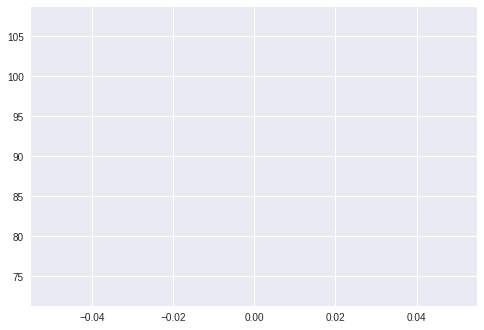

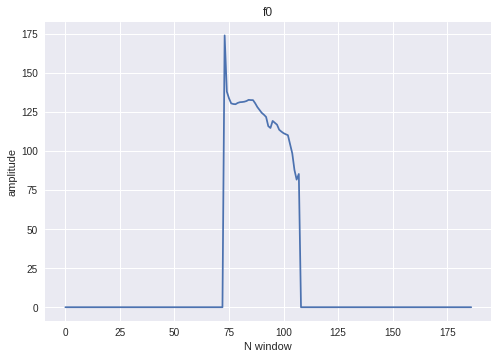

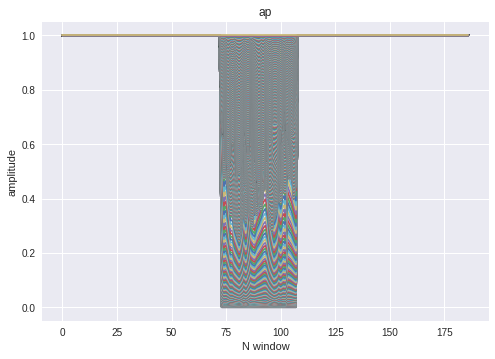

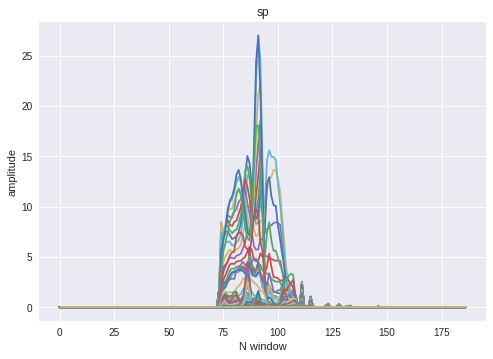

In [158]:
#sf.write(basePath + "/sounds/tsjavi.wav", ts_javi[2,:], fs)
configure_plotly_browser_state()
init_notebook_mode(connected=False)

f0, sp, ap = pw.wav2world(ts_javi[7,:], fs)
f0_a, sp_a, ap_a = pw.wav2world(ts_alb[7,:], fs)
y = pw.synthesize(f0,sp,ap,fs,pw.default_frame_period)

sf.write(basePath + "/sounds/tsjavi_rec2.wav", y, fs)
#wavPlayer(basePath + "/sounds/tsjavi_rec2.wav")


trace = go.Scatter(
    x = range(Nwindows),
    y = f0,
    mode = 'lines',
    name = 'lines'
)

# Edit the layout
layout = dict(title = 'F0',
              xaxis = dict(title = 'Window'),
              yaxis = dict(title = 'Frequency'),
              )

fig = dict(data=[trace], layout=layout)
iplot(fig)


plt.figure()
plt.plot(np.where(f0))


print(f0.shape)
print(sp.shape)
print(ap.shape)
print(sp_a.shape)

Nwindows = f0.shape[0]
plt.figure()
plt.plot(range(Nwindows), f0)
plt.title("f0")
plt.xlabel("N window")
plt.ylabel("amplitude")

plt.figure()
plt.plot(range(Nwindows), ap)
plt.title("ap")
plt.xlabel("N window")
plt.ylabel("amplitude")


plt.figure()
plt.plot(sp)
plt.title("sp")
plt.xlabel("N window")
plt.ylabel("amplitude")



#print("Nwindows = %d" % Nwindows)
#print(sp.shape)


 




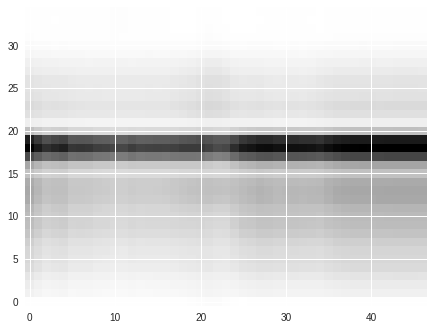

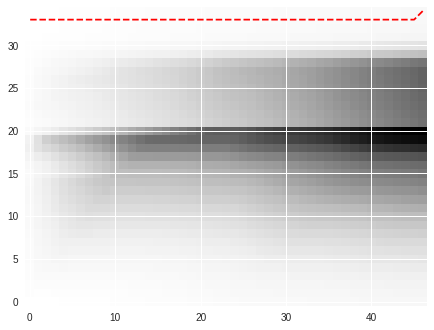

In [79]:
# sp = sp[f0 != 0]
# sp_a = sp_a[f0_a != 0]

t = sp_a
s = sp


D = elementwyse_l2(s, t)
C = genate_Cmtx(D)

start = [C.shape[0]-1, C.shape[1]-1]

posV, posH = dtw_backtracking(C, start)

plt.figure()
plt.imshow(D)
plt.gca().invert_yaxis()
plt.figure()
plt.imshow(C)
plt.plot(posH, posV, 'r--')
plt.gca().invert_yaxis()

ValueError: ignored

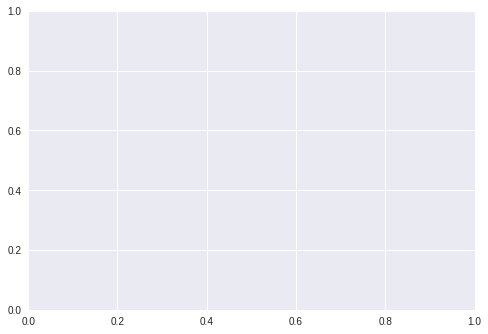

In [0]:

plt.figure()
plt.plot(range(Nwindows), f0)
plt.title("f0")
plt.xlabel("N window")
plt.ylabel("amplitude")

f0, sp, ap = pw.wav2world(x_raq, fs)
Nwindows = f0.shape[0]
plt.figure()
plt.plot(range(Nwindows), f0)
plt.title("f0")
plt.xlabel("N window")
plt.ylabel("amplitude")


f0, sp, ap = pw.wav2world(x_alb, fs)
Nwindows = f0.shape[0]
plt.figure()
plt.plot(range(Nwindows), f0)
plt.title("f0")
plt.xlabel("N window")
plt.ylabel("amplitude")